# Dueling Networks from Scratch

The dueling architecture explicitly separates the representation of state values from (state-dependent) action advantage values.

# Imports & Constants

In [10]:
import os
from typing import Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_

from buffers import ReplayBuffer
import time

# Dueling Network

In [2]:
class DuelingNetwork(nn.Module):

    def __init__(self, in_dim: int, out_dim: int):
        """
        Instantiates a Duelling Neural Network.
        """
        super().__init__()

        # Common feature layer.
        self.feature_layer = nn.Sequential(
            nn.Linear(in_dim, 128),
            nn.ReLU(),
        )

        # Advantage layer
        self.advantage_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, out_dim),
        )

        # Value layer
        self.value_layer = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        feature = self.feature_layer(x)

        s_value = self.value_layer(feature)
        advantage = self.advantage_layer(feature)

        q_value = s_value + advantage - advantage.mean(dim=-1, keepdim=True)

        return q_value

# Dueling DQN Agent

In [4]:
class DuelingDQNAgent:
    """
    Class representing a DQN agent with Dueling Networks.
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        obs_dim = np.prod(env.observation_space.shape)
        action_dim = env.action_space.n

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma

        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # Networks: DQN behaviour network, DQN target network
        self.dqn = DuelingNetwork(obs_dim, action_dim).to(self.device)
        self.dqn_target = DuelingNetwork(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # Optimiser
        self.optimiser = optim.Adam(self.dqn.parameters())

        # Transition to store in memory
        self.transition = list()

        # Mode: train/test.
        self.is_test = False

    def predict(self, state: np.ndarray, determinstic: bool = True) -> np.ndarray:
        """
        Selects an action from the input state using a (potentially) epsilon-greedy policy.
        """
        return self.select_action(state, determinstic)

    def select_action(self, state: np.ndarray, determinstic: bool = False) -> np.ndarray:
        """
        Selects an action from the input state using an epsilon-greedy policy.
        """
        if not determinstic and np.random.random() < self.epsilon:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action
    
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """
        Takes an action and returns the response of the env.
        """
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        next_state = next_state.flatten()

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        return next_state, reward, done
    
    def update_model(self) -> torch.Tensor:
        """
        Updates the model by gradient descent.
        """
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)
        
        self.optimiser.zero_grad()
        loss.backward()

        # Dueling DQN: We clip the gradients to have their norm less than or equal to 10.
        clip_grad_norm_(self.dqn.parameters(), 10.0)

        self.optimiser.step()

        return loss.item()
    
    def train(self, num_frames: int, plotting_interval: int = 200):
        """
        Trains the agent.
        """
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        state = state.flatten() # Necessary for the highway environment

        update_count = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            if done:
                # The episode has ended.
                state, _ = self.env.reset(seed=self.seed)
                state = state.flatten()
                
                scores.append(score)
                score = 0

            if len(self.memory) >= self.batch_size:
                # Training is ready once the replay buffer contains enough transition samples.
                loss = self.update_model()
                losses.append(loss)
                update_count += 1

                # Linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon,
                    self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)

                # If a hard update of the target network is needed.
                if update_count % self.target_update == 0:
                    self._target_hard_update()

            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)

        self.env.close()

    def test(self, video_folder: str) -> None:
        """
        Tests the agent.
        """
        self.is_test =True
        
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)

        state, _ = self.env.reset(seed=self.seed)
        state = state.flatten()

        done = False
        score = 0
        
        while not done:
            action = self.predict(state)
            next_state, reward, done = self.step(action)
            next_state = next_state.flatten()

            state = next_state
            score += reward

        print("score: ", score)
        self.env.close()

        # Reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """
        Computes and returns the DQN loss.
        """
        device = self.device

        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t = r + gamma * v(s_{t+1}) if state != terminal
        #     = r                      otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(next_state).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(device)

        # Calculate DQN loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """
        Performs a hard update of the target network: target <- behavioural.
        """
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plots the training progress."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

# Train an agent

In [12]:
env = gym.make("highway-fast-v0", render_mode="rgb_array")

seed = 777

def seed_torch(seed: int):
    torch.manual_seed(seed)

    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

num_frames = 50_000
memory_size = 15_000
gamma = 0.8
batch_size = 64
target_update = 50
epsilon_decay = 1 / 10_000

agent = DuelingDQNAgent(
    env,
    memory_size,
    batch_size,
    target_update,
    epsilon_decay,
    seed,
    gamma = gamma
)

cuda


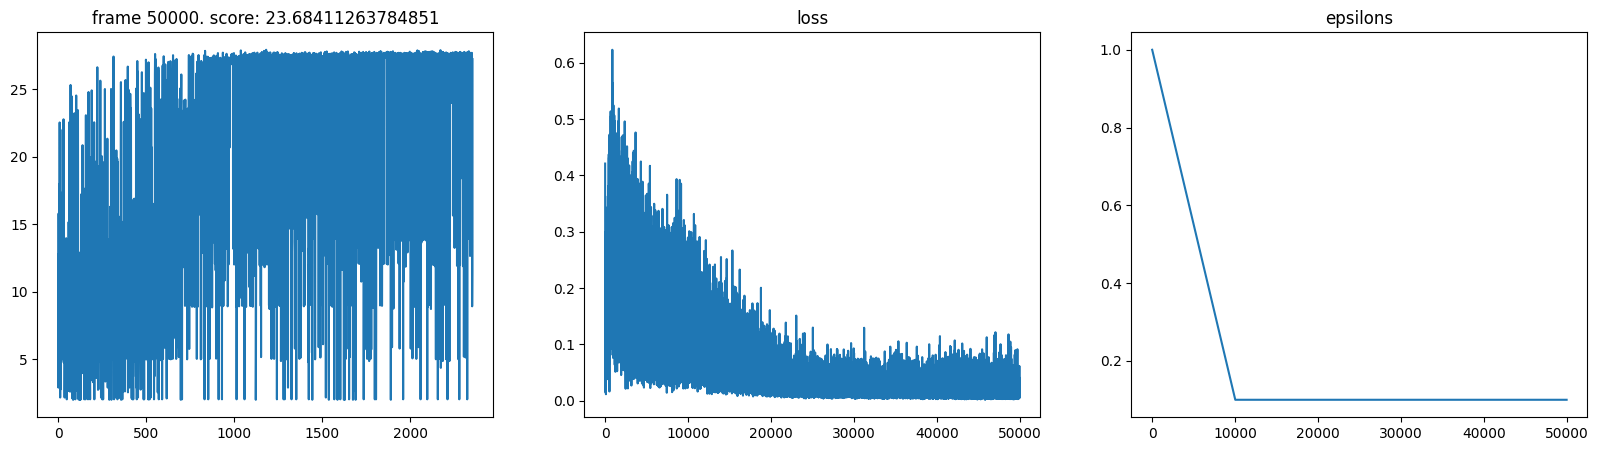

In [13]:
agent.train(num_frames)

# Test the agent

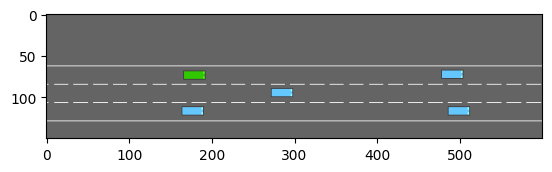

KeyboardInterrupt: 

In [11]:
while True:
    done = truncated = False
    obs, info = env.reset()
    obs = obs.flatten()

    while not (done or truncated):
        action = agent.predict(obs, True)
        obs, reward, done, truncated, info = env.step(action)
        obs = obs.flatten()

        clear_output(True)
        plt.imshow(env.render())
        plt.show()
        time.sleep(0.1)